In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGiNG")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'
strategy.ret.loc['2013-01-02'] = strategy.ret.loc['2013-01-03']

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

2019-10-30 20:30:48,868 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:30:48,871 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:30:48,871 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [6]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

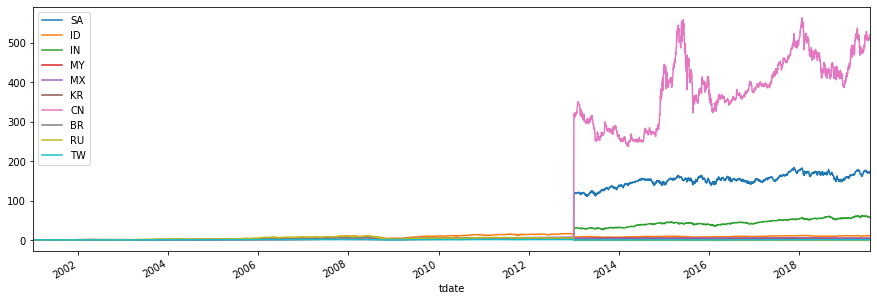

In [7]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

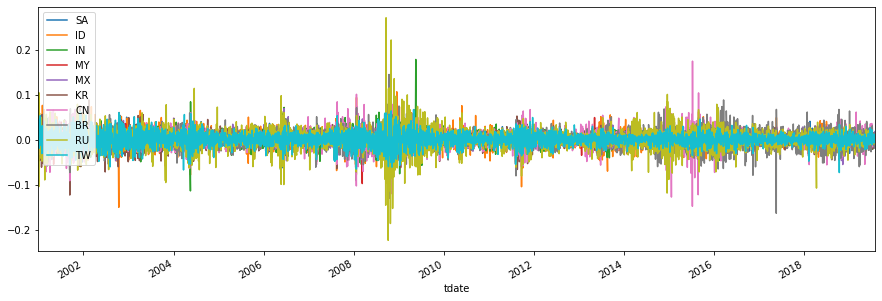

In [8]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [9]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### moving average 와 주가 차이

In [10]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [11]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [12]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [13]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EMPM_PAST.png">

<img src="./result/EMPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [14]:
one_week = 5
one_month = 20

In [15]:
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 

### binary - 50%

In [16]:
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [17]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [18]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [19]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [20]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [21]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.691476	valid_1's binary_logloss: 0.691476
[20]	training's binary_logloss: 0.689981	valid_1's binary_logloss: 0.689981
[30]	training's binary_logloss: 0.688638	valid_1's binary_logloss: 0.688638
[40]	training's binary_logloss: 0.687368	valid_1's binary_logloss: 0.687368
[50]	training's binary_logloss: 0.686219	valid_1's binary_logloss: 0.686219
[60]	training's binary_logloss: 0.685197	valid_1's binary_logloss: 0.685197
[70]	training's binary_logloss: 0.684266	valid_1's binary_logloss: 0.684266
[80]	training's binary_logloss: 0.683359	valid_1's binary_logloss: 0.683359
[90]	training's binary_logloss: 0.68251	valid_1's binary_logloss: 0.68251
[100]	training's binary_logloss: 0.681709	valid_1's binary_logloss: 0.681709
[110]	training's binary_logloss: 0.680926	valid_1's binary_logloss: 0.680926
[120]	training's binary_logloss: 0.680208	valid_1's binary_logloss: 0.680208
[130]	training's binary_l

In [22]:
test_pred = model.predict(df_test_x.values)

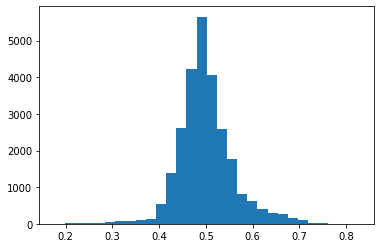

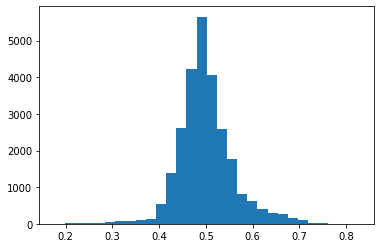

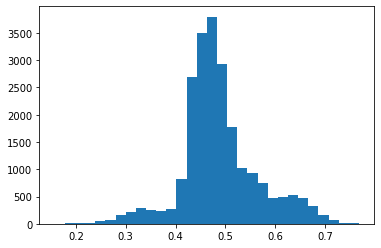

In [23]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [24]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [26]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [27]:
df_index_sub = df_index.loc['1994':]

In [28]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [29]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [30]:
strategy.set_rebalance_period(freq='month', rebalance_weekday=1) 

2019-10-30 20:30:57,889 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [31]:
tester = Tester(strategy)

In [32]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [33]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-10-30 20:30:59,017 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:30:59,018 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:30:59,018 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:31:05,776 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 20:31:05,777 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 20:31:07,421 - EMPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 20:31:07,427 - EMPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-30 20:31:08,434 - EMPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-30 20:31:08,437 - EMPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-30 20:31:08,438 - EMPM - INFO - [STEP 5 - 3 - 1] NO TARGET VOL CONTROL to CS POSITION
2019-10-30 20:31:08,438 - EMPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-30 20:31:11,102 - EMPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITIO

### TRAIN

2019-10-30 20:31:12,249 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:12,250 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:12,255 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:12,261 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


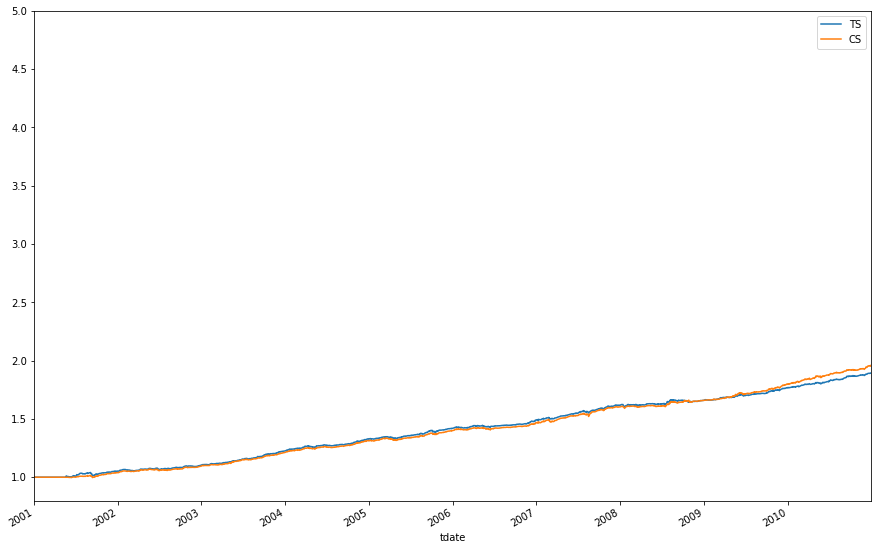

In [34]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-30 20:31:53,025 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:53,026 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:53,033 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:53,039 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


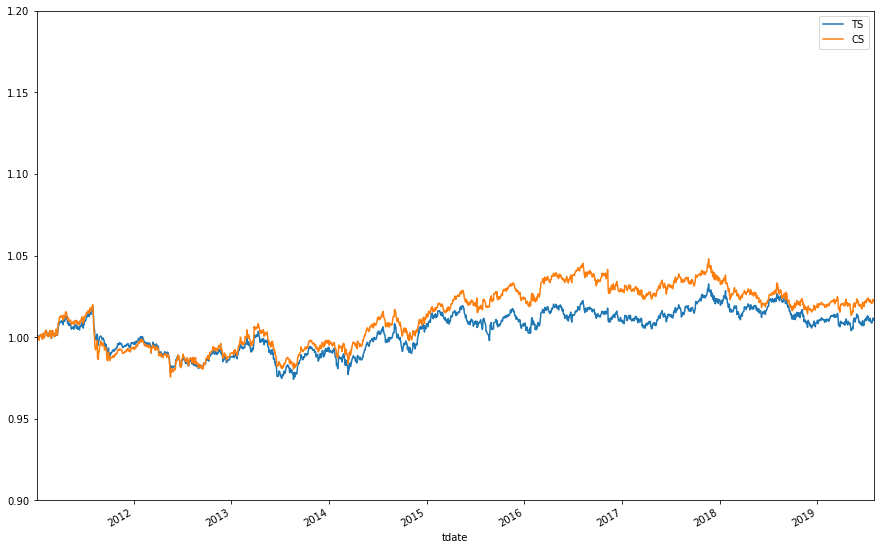

In [36]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.2))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [38]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [39]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [40]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [41]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [42]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [43]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [44]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.670149	valid_1's binary_logloss: 0.706722
[20]	training's binary_logloss: 0.667697	valid_1's binary_logloss: 0.706434
[30]	training's binary_logloss: 0.665509	valid_1's binary_logloss: 0.705867
[40]	training's binary_logloss: 0.663269	valid_1's binary_logloss: 0.70565
[50]	training's binary_logloss: 0.661067	valid_1's binary_logloss: 0.705383
[60]	training's binary_logloss: 0.659042	valid_1's binary_logloss: 0.70519
[70]	training's binary_logloss: 0.657332	valid_1's binary_logloss: 0.705008
[80]	training's binary_logloss: 0.655676	valid_1's binary_logloss: 0.704897
[90]	training's binary_logloss: 0.654163	valid_1's binary_logloss: 0.704752
[100]	training's binary_logloss: 0.652838	valid_1's binary_logloss: 0.704714
[110]	training's binary_logloss: 0.651329	valid_1's binary_logloss: 0.704727
[120]	training's binary_logloss: 0.649947	valid_1's binary_logloss: 0.704681
[130]	training's binary_l

In [45]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([  19.,   46.,   51.,   73.,  150.,  337.,  286.,  336.,  368.,
         385.,  425.,  629.,  806., 1203., 2181., 5014., 5597., 5919.,
        6472., 5485., 4196., 3042., 2042., 1485.,  862.,  463.,  237.,
         156.,   59.,   16.]),
 array([0.1565628 , 0.18072662, 0.20489044, 0.22905426, 0.25321809,
        0.27738191, 0.30154573, 0.32570955, 0.34987338, 0.3740372 ,
        0.39820102, 0.42236484, 0.44652867, 0.47069249, 0.49485631,
        0.51902013, 0.54318395, 0.56734778, 0.5915116 , 0.61567542,
        0.63983924, 0.66400307, 0.68816689, 0.71233071, 0.73649453,
        0.76065836, 0.78482218, 0.808986  , 0.83314982, 0.85731365,
        0.88147747]),
 <a list of 30 Patch objects>)

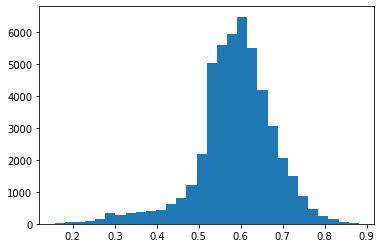

In [46]:
plt.hist(pred2, bins=30)

In [47]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [48]:
strategy2 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'
strategy2.ret.loc['2013-01-02'] = strategy2.ret.loc['2013-01-03']


strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-30 20:32:09,153 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:32:09,153 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:32:09,154 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:32:09,154 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:32:09,155 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:32:09,155 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [49]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2019-10-30 20:32:10,984 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:32:10,984 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:32:10,986 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:32:10,986 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:32:10,986 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:32:10,986 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:32:10,987 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:32:10,987 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:32:17,741 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 20:32:17,741 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 20:32:17,742 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 20:32:17,742 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 20:32:19,389 - EMPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 20:32:19

### TRAIN

2019-10-30 20:32:24,210 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:32:24,210 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:32:24,211 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:32:24,211 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:32:24,218 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:32:24,218 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:32:24,224 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 20:32:24,224 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


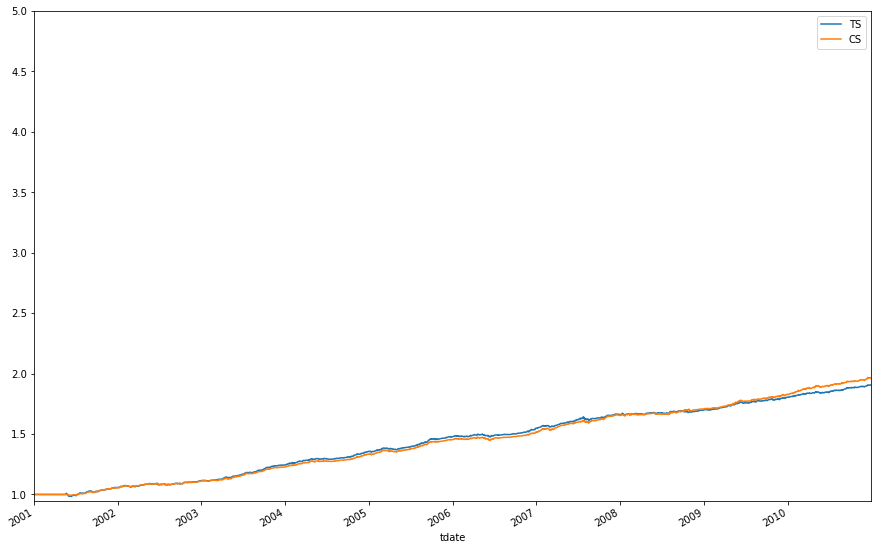

In [50]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-30 20:32:24,377 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:32:24,377 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:32:24,378 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:32:24,378 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:32:24,384 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:32:24,384 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:32:24,391 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 20:32:24,391 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


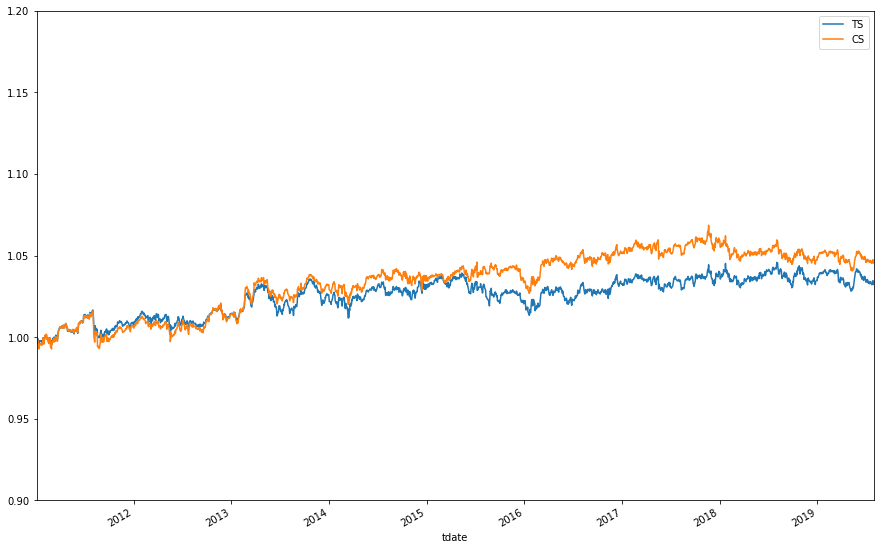

In [51]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.2))

# CASE 3. Case1을 Rolling으로 실행

In [52]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [53]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [54]:
models = []
train_preds = []
test_preds = []

In [55]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.691476	valid_1's binary_logloss: 0.692567
[20]	training's binary_logloss: 0.689981	valid_1's binary_logloss: 0.692191
[30]	training's binary_logloss: 0.688638	valid_1's binary_logloss: 0.692029
[40]	training's binary_logloss: 0.687368	valid_1's binary_logloss: 0.692325
[50]	training's binary_logloss: 0.686219	valid_1's binary_logloss: 0.692457
[60]	training's binary_logloss: 0.685197	valid_1's binary_logloss: 0.692743
[70]	training's binary_logloss: 0.684266	valid_1's binary_logloss: 0.692781
[80]	training's binary_logloss: 0.683359	valid_1's binary_logloss: 0.692728
[90]	training's binary_logloss: 0.68251	valid_1's binary_logloss: 0.692914
[100]	training's binary_logloss: 0.681709	valid_1's binary_logloss: 0.692797
[110]	training's binary_logloss: 0.680926	valid_1's binary_logloss: 0.692841
[120]	training's binary_logloss: 0.680208	valid_1's binary_logloss: 0.692792
[130]	training's binary_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[10]	training's binary_logloss: 0.69167	valid_1's binary_logloss: 0.692662
[20]	training's binary_logloss: 0.69034	valid_1's binary_logloss: 0.692236
[30]	training's binary_logloss: 0.689141	valid_1's binary_logloss: 0.692018
[40]	training's binary_logloss: 0.688014	valid_1's binary_logloss: 0.691941
[50]	training's binary_logloss: 0.687065	valid_1's binary_logloss: 0.691855
[60]	training's binary_logloss: 0.686258	valid_1's binary_logloss: 0.691838
[70]	training's binary_logloss: 0.685452	valid_1's binary_logloss: 0.691834
[80]	training's binary_logloss: 0.684678	valid_1's binary_logloss: 0.691787
[90]	training's binary_logloss: 0.683884	valid_1's binary_logloss: 0.69176
[100]	training's binary_logloss: 0.68326	valid_1's binary_logloss: 0.691822
[110]	training's binary_logloss: 0.682543	valid_1's binary_logloss: 0.691918
[120]	training's binary_logloss: 0.681857	valid_1's binary_logloss: 0.691939
[130]	training's binary_logloss: 0.681137	valid_1's binary_logloss: 0.692006
[140]	train

[140]	training's binary_logloss: 0.681049	valid_1's binary_logloss: 0.693543
[150]	training's binary_logloss: 0.680435	valid_1's binary_logloss: 0.693695
[160]	training's binary_logloss: 0.67973	valid_1's binary_logloss: 0.69412
[170]	training's binary_logloss: 0.678995	valid_1's binary_logloss: 0.694193
[180]	training's binary_logloss: 0.678346	valid_1's binary_logloss: 0.694227
[190]	training's binary_logloss: 0.677763	valid_1's binary_logloss: 0.694438
[200]	training's binary_logloss: 0.677126	valid_1's binary_logloss: 0.694347
[210]	training's binary_logloss: 0.676485	valid_1's binary_logloss: 0.694434
[220]	training's binary_logloss: 0.675843	valid_1's binary_logloss: 0.694147
[230]	training's binary_logloss: 0.675261	valid_1's binary_logloss: 0.69424
[240]	training's binary_logloss: 0.674642	valid_1's binary_logloss: 0.694477
[250]	training's binary_logloss: 0.67404	valid_1's binary_logloss: 0.69459
[260]	training's binary_logloss: 0.673559	valid_1's binary_logloss: 0.694636
[270

[170]	training's binary_logloss: 0.678809	valid_1's binary_logloss: 0.701835
[180]	training's binary_logloss: 0.678284	valid_1's binary_logloss: 0.702346
[190]	training's binary_logloss: 0.677717	valid_1's binary_logloss: 0.703032
[200]	training's binary_logloss: 0.677154	valid_1's binary_logloss: 0.70348
[210]	training's binary_logloss: 0.676629	valid_1's binary_logloss: 0.70386
[220]	training's binary_logloss: 0.676121	valid_1's binary_logloss: 0.704169
[230]	training's binary_logloss: 0.675611	valid_1's binary_logloss: 0.704475
[240]	training's binary_logloss: 0.675148	valid_1's binary_logloss: 0.704984
[250]	training's binary_logloss: 0.674642	valid_1's binary_logloss: 0.705358
[260]	training's binary_logloss: 0.674177	valid_1's binary_logloss: 0.705828
[270]	training's binary_logloss: 0.673641	valid_1's binary_logloss: 0.70614
[280]	training's binary_logloss: 0.673119	valid_1's binary_logloss: 0.706367
[290]	training's binary_logloss: 0.672676	valid_1's binary_logloss: 0.706908
[3

[270]	training's binary_logloss: 0.67616	valid_1's binary_logloss: 0.693239
[280]	training's binary_logloss: 0.675772	valid_1's binary_logloss: 0.693147
[290]	training's binary_logloss: 0.675312	valid_1's binary_logloss: 0.693145
[300]	training's binary_logloss: 0.674869	valid_1's binary_logloss: 0.693111
[310]	training's binary_logloss: 0.674444	valid_1's binary_logloss: 0.693227
[320]	training's binary_logloss: 0.673889	valid_1's binary_logloss: 0.693067
[330]	training's binary_logloss: 0.673538	valid_1's binary_logloss: 0.692956
[340]	training's binary_logloss: 0.673063	valid_1's binary_logloss: 0.693013
[350]	training's binary_logloss: 0.672605	valid_1's binary_logloss: 0.692807
[360]	training's binary_logloss: 0.67217	valid_1's binary_logloss: 0.692961
[370]	training's binary_logloss: 0.671728	valid_1's binary_logloss: 0.692906
[380]	training's binary_logloss: 0.671307	valid_1's binary_logloss: 0.693154
[390]	training's binary_logloss: 0.670929	valid_1's binary_logloss: 0.693137
[

In [56]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([  11.,   13.,   23.,   32.,   73.,   59.,   71.,  116.,  159.,
         122.,  221.,  267.,  647., 2482., 3734., 3214., 3048., 2264.,
        1710., 1412., 1038.,  613.,  333.,  189.,  167.,  127.,  130.,
          47.,   18.,   10.]),
 array([0.17889757, 0.19815198, 0.21740638, 0.23666079, 0.25591519,
        0.27516959, 0.294424  , 0.3136784 , 0.3329328 , 0.35218721,
        0.37144161, 0.39069601, 0.40995042, 0.42920482, 0.44845922,
        0.46771363, 0.48696803, 0.50622244, 0.52547684, 0.54473124,
        0.56398565, 0.58324005, 0.60249445, 0.62174886, 0.64100326,
        0.66025766, 0.67951207, 0.69876647, 0.71802087, 0.73727528,
        0.75652968]),
 <a list of 30 Patch objects>)

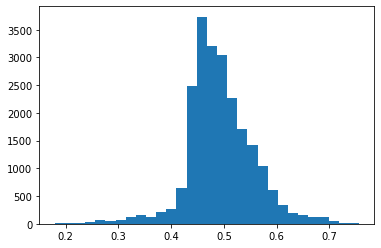

In [57]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [58]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [62]:
strategy3 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'
strategy3.ret.loc['2013-01-02'] = strategy3.ret.loc['2013-01-03']


strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-30 20:32:50,666 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:32:50,666 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:32:50,666 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:32:50,666 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:32:50,669 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:32:50,669 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:32:50,669 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:32:50,669 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:32:50,670 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:32:50,670 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:32:50,670 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:32:50,670 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [63]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-10-30 20:32:50,700 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:32:50,700 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:32:50,700 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:32:50,700 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:32:50,702 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:32:50,702 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:32:50,702 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:32:50,702 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:32:50,703 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:32:50,703 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:32:50,703 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:32:50,703 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:32:50,704 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:32:50,704 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:32:50,704 

2019-10-30 20:33:16,968 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:33:16,968 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:33:16,968 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:33:16,968 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:33:16,969 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:33:16,969 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:33:16,969 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:33:16,969 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:33:16,977 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:33:16,977 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:33:16,977 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:33:16,977 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:33:16,983 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 20:33:16,983 - 

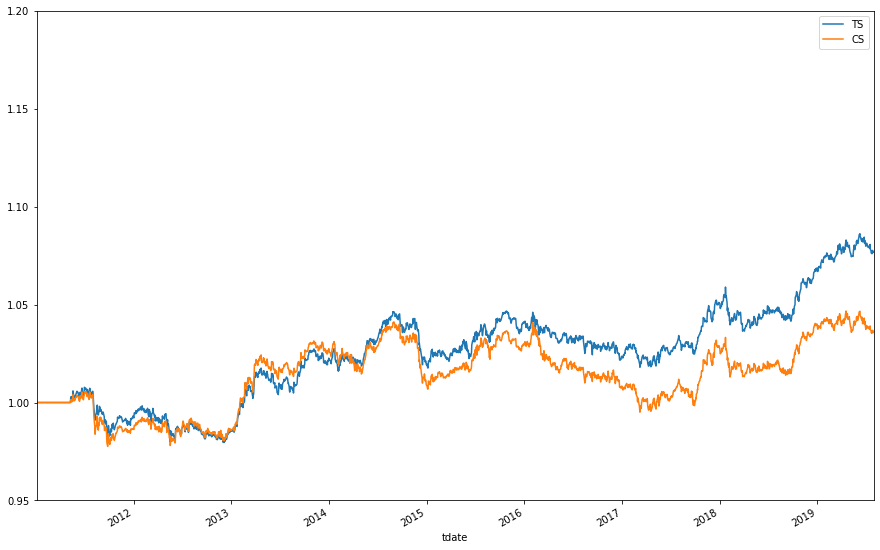

In [66]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))

# CASE 4. CASE 2를 ROLLING으로 실행

In [67]:
models = []
train_preds = []
test_preds = []

In [68]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.670149	valid_1's binary_logloss: 0.711718
[20]	training's binary_logloss: 0.667697	valid_1's binary_logloss: 0.705879
[30]	training's binary_logloss: 0.665509	valid_1's binary_logloss: 0.703723
[40]	training's binary_logloss: 0.663269	valid_1's binary_logloss: 0.702946
[50]	training's binary_logloss: 0.661067	valid_1's binary_logloss: 0.702163
[60]	training's binary_logloss: 0.659042	valid_1's binary_logloss: 0.700963
[70]	training's binary_logloss: 0.657332	valid_1's binary_logloss: 0.70096
[80]	training's binary_logloss: 0.655676	valid_1's binary_logloss: 0.700673
[90]	training's binary_logloss: 0.654163	valid_1's binary_logloss: 0.700341
[100]	training's binary_logloss: 0.652838	valid_1's binary_logloss: 0.699646
[110]	training's binary_logloss: 0.651329	valid_1's binary_logloss: 0.699792
[120]	training's binary_logloss: 0.649947	valid_1's binary_logloss: 0.699968
[130]	training's binary_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[10]	training's binary_logloss: 0.669949	valid_1's binary_logloss: 0.709494
[20]	training's binary_logloss: 0.667623	valid_1's binary_logloss: 0.706671
[30]	training's binary_logloss: 0.665453	valid_1's binary_logloss: 0.704723
[40]	training's binary_logloss: 0.663475	valid_1's binary_logloss: 0.704397
[50]	training's binary_logloss: 0.661507	valid_1's binary_logloss: 0.70361
[60]	training's binary_logloss: 0.65958	valid_1's binary_logloss: 0.704708
[70]	training's binary_logloss: 0.658102	valid_1's binary_logloss: 0.70356
[80]	training's binary_logloss: 0.656639	valid_1's binary_logloss: 0.701668
[90]	training's binary_logloss: 0.655026	valid_1's binary_logloss: 0.700206
[100]	training's binary_logloss: 0.653609	valid_1's binary_logloss: 0.699942
[110]	training's binary_logloss: 0.652254	valid_1's binary_logloss: 0.699608
[120]	training's binary_logloss: 0.65103	valid_1's binary_logloss: 0.699459
[130]	training's binary_logloss: 0.649823	valid_1's binary_logloss: 0.698103
[140]	train

[40]	training's binary_logloss: 0.664224	valid_1's binary_logloss: 0.71511
[50]	training's binary_logloss: 0.662367	valid_1's binary_logloss: 0.716376
[60]	training's binary_logloss: 0.660714	valid_1's binary_logloss: 0.716329
[70]	training's binary_logloss: 0.659189	valid_1's binary_logloss: 0.7168
[80]	training's binary_logloss: 0.657692	valid_1's binary_logloss: 0.719965
[90]	training's binary_logloss: 0.655859	valid_1's binary_logloss: 0.721549
[100]	training's binary_logloss: 0.654106	valid_1's binary_logloss: 0.720159
[110]	training's binary_logloss: 0.652614	valid_1's binary_logloss: 0.719854
[120]	training's binary_logloss: 0.651234	valid_1's binary_logloss: 0.718317
[130]	training's binary_logloss: 0.649875	valid_1's binary_logloss: 0.719997
[140]	training's binary_logloss: 0.648539	valid_1's binary_logloss: 0.7196
[150]	training's binary_logloss: 0.647171	valid_1's binary_logloss: 0.718312
[160]	training's binary_logloss: 0.645832	valid_1's binary_logloss: 0.715683
[170]	trai

[170]	training's binary_logloss: 0.644711	valid_1's binary_logloss: 0.70908
[180]	training's binary_logloss: 0.643563	valid_1's binary_logloss: 0.707861
[190]	training's binary_logloss: 0.642291	valid_1's binary_logloss: 0.708803
[200]	training's binary_logloss: 0.641025	valid_1's binary_logloss: 0.709094
[210]	training's binary_logloss: 0.639836	valid_1's binary_logloss: 0.709184
[220]	training's binary_logloss: 0.638574	valid_1's binary_logloss: 0.708445
[230]	training's binary_logloss: 0.6376	valid_1's binary_logloss: 0.70871
[240]	training's binary_logloss: 0.636428	valid_1's binary_logloss: 0.709157
[250]	training's binary_logloss: 0.635505	valid_1's binary_logloss: 0.70873
[260]	training's binary_logloss: 0.634383	valid_1's binary_logloss: 0.708151
[270]	training's binary_logloss: 0.633322	valid_1's binary_logloss: 0.707935
[280]	training's binary_logloss: 0.632314	valid_1's binary_logloss: 0.70829
[290]	training's binary_logloss: 0.631185	valid_1's binary_logloss: 0.708487
[300]

[370]	training's binary_logloss: 0.629356	valid_1's binary_logloss: 0.700906
[380]	training's binary_logloss: 0.628458	valid_1's binary_logloss: 0.700701
[390]	training's binary_logloss: 0.627698	valid_1's binary_logloss: 0.701006
[400]	training's binary_logloss: 0.62681	valid_1's binary_logloss: 0.700728
[410]	training's binary_logloss: 0.62595	valid_1's binary_logloss: 0.700554
[420]	training's binary_logloss: 0.625155	valid_1's binary_logloss: 0.700693
[430]	training's binary_logloss: 0.624343	valid_1's binary_logloss: 0.700784
[440]	training's binary_logloss: 0.623661	valid_1's binary_logloss: 0.701206
[450]	training's binary_logloss: 0.622836	valid_1's binary_logloss: 0.701524
[460]	training's binary_logloss: 0.622114	valid_1's binary_logloss: 0.701592
[470]	training's binary_logloss: 0.62136	valid_1's binary_logloss: 0.701807
[480]	training's binary_logloss: 0.620621	valid_1's binary_logloss: 0.702176
[490]	training's binary_logloss: 0.61984	valid_1's binary_logloss: 0.702223
[50

In [69]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [70]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [71]:
strategy4 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'
strategy4.ret.loc['2013-01-02'] = strategy4.ret.loc['2013-01-03']


strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-30 20:33:35,840 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:33:35,840 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:33:35,840 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:33:35,840 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:33:35,840 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:33:35,843 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:33:35,843 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:33:35,843 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:33:35,843 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:33:35,843 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:33:35,844 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:33:35,844 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:33:35,844 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:33:35,844 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:33:35,844 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [72]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-10-30 20:33:41,775 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:33:41,775 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:33:41,775 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:33:41,775 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:33:41,775 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:33:41,777 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:33:41,777 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:33:41,777 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:33:41,777 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:33:41,777 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:33:41,779 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:33:41,779 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:33:41,779 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:33:41,779 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:33:41,779 - EMP

2019-10-30 20:34:32,310 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:34:32,310 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:34:32,310 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:34:32,310 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:34:32,310 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:34:32,313 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:34:32,313 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:34:32,313 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:34:32,313 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:34:32,313 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:34:32,320 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:34:32,320 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:34:32,320 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:34:32,320 - EMPM - INF

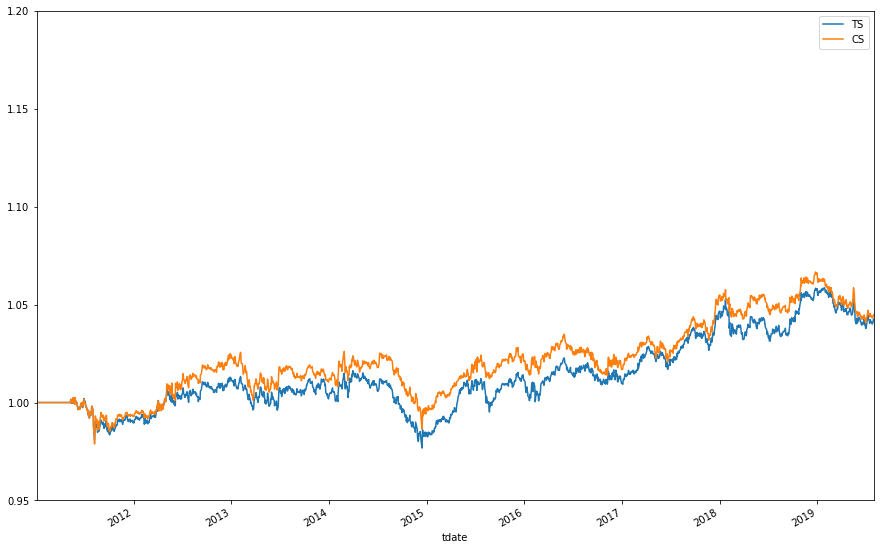

In [74]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))